# VAE for CIFAR10

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
#from tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
% matplotlib inline

## Set Hyperparameter

In [2]:
batch_size=64
learning_rate=0.0003
num_epoch=20
leak=0.05
drop_rate=0.1
z_dim=64

## CIFAR10 dataset.
It has 10 classes: 

‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. 

The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

In [3]:
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
# Transforms are common image transforms. They can be chained together using `Compose`

transform_config = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

In [4]:
# Download the data
cifar_train=dset.CIFAR10(root="../data/", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
cifar_test=dset.CIFAR10(root="../data/", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

Files already downloaded and verified


In [5]:
train_loader=torch.utils.data.DataLoader(cifar_train,batch_size=batch_size, shuffle=True, num_workers=2,drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test,batch_size=batch_size,shuffle=False,num_workers=2,drop_last=True)

## Model


### Encoder
* Two outputs
    * z_mu
    * z_logvar

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        
        # output size = (image_width - kernel_width)/stride +1
        
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size,
        #                 stride=1, padding=0, dilation=1,
        #                 groups=1, bias=True)



        self.conv_layer = nn.Sequential(
                        nn.Conv2d(3,64,3,padding=1),
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU(leak),
                        nn.Dropout(p=drop_rate,inplace=True),
                        # batch_size*  32*32  *64 featuremaps
            
                        nn.Conv2d(64,128,3,padding=1), 
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(leak),
                        nn.Dropout(p=drop_rate,inplace=True),
                        nn.MaxPool2d(2,2),
                        # batch_size*  16*16  *128 featuremaps
            
                        nn.Conv2d(128,256,3,padding=1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(leak),
                        nn.Dropout(p=drop_rate,inplace=True),
                        nn.MaxPool2d(2,2),
                        # batch_size*  8*8  *256 featuremaps
            
            
                        nn.Conv2d(256,256,3,padding=1,stride=2), # ((8+1*2) - 3)/2 +1 = 4
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(leak),
                        nn.Dropout(p=drop_rate,inplace=True),
                        # batch_size*  4*4  *256 featuremaps
                
                        nn.Conv2d(256,1024,4, padding=0),  # ((4 - 2)/1 +1 = 28
                        nn.BatchNorm2d(1024),
                        nn.LeakyReLU(leak)
                        # batch_size*  1*1  *1024 featuremaps
            
        )
        
        self.fc_layer = nn.Sequential(
                        nn.Linear(1*1*1024,512),
                        nn.LeakyReLU(leak),
                        nn.Dropout(p=drop_rate,inplace=True),
                        nn.Linear(512,128),
                        nn.LeakyReLU(leak)
        )
   
        # ===== Two output vectors generated by the Encoder =====
        
        # One for z_mu
        self.z_mu=nn.Sequential(
            nn.Linear(128,z_dim),
            nn.LeakyReLU(leak)
        )
        
        # Another for z_logvar
        self.z_logvar=nn.Sequential(
            nn.Linear(128,z_dim),
            nn.LeakyReLU(leak)
        )
        
        
    def forward(self,x):
        out=self.conv_layer(x)
        out=out.view(batch_size,-1)
        
        out=self.fc_layer(out)

        z_mu=self.z_mu(out)
        z_logvar=self.z_logvar(out)
        
        return z_mu,z_logvar

### Decoder
* input: sampled_z
* output: reconstructed image

In [22]:
# torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
#   output_padding=0, groups=1, bias=True, dilation=1)

# H_out=(H_in−1)∗stride(4th) + kernel_size(3rd) − 2∗padding(5th) + output_padding

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        self.fc_layer=nn.Sequential(
            nn.Linear(z_dim,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(leak),
            nn.Dropout(p=drop_rate,inplace=True),
            
            nn.Linear(128,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(leak),
            nn.Dropout(p=drop_rate,inplace=True),
            
            nn.Linear(256,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(leak),
            nn.Dropout(p=drop_rate,inplace=True),
            
            nn.Linear(1024,512*2*2),
            nn.BatchNorm1d(512*2*2),
            nn.LeakyReLU(leak)
        )
        
        self.transConv_layer=nn.Sequential(
            
            nn.ConvTranspose2d(512,256,3,2,1,1), 
            nn.BatchNorm2d(256),
            nn.LeakyReLU(leak),
            # 4*4
            
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(256,256,3,1,1,0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(leak),
            # 8*8
            
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(256,128,3,1,1,0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(leak),
            # 16*16
            
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(128,64,3,1,1,0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(leak),
            # 32*32
            
            nn.ConvTranspose2d(64,3,3,1,1,0),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
            # 32*32
            
        )
    
    # decode the sampled_z
    def forward(self,sampled_z):

        out=self.fc_layer(sampled_z)
        out=out.view(batch_size,-1,2,2)
        out=self.transConv_layer(out)

        return out

In [23]:
## check GPU availability here bro
use_gpu = torch.cuda.is_available()

### the Model as a whole
* encoder & decoder
* sample z

In [24]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE,self).__init__()
        
        self.encoder=encoder
        self.decoder=decoder
    
    def sample_z(self, z_mu,z_logvar):
        
        # sample epsilon ~ N(0, 1)
        
        epsilon=Variable(torch.randn(batch_size,z_dim),requires_grad=False)
        if use_gpu:
            epsilon = epsilon.cuda()
        else:
            pass
        
        # reparameterization trick
        sampled_z=z_mu+torch.mul(torch.exp(z_logvar),epsilon)
       
        return sampled_z
        
            
    def forward(self,x):
        # encode the latent variable from the image
        # sample z from the encoded result
        # decode the sampled z
        
        z_mu,z_logvar=self.encoder(x)
        
        self.z_mu=z_mu
        self.z_logvar=z_logvar

        sampled_z=self.sample_z(z_mu,z_logvar)

        result=self.decoder(sampled_z)
        
        return result

### Check GPU availibility

In [25]:

if use_gpu:
    model = VAE(Encoder(),Decoder()).cuda()
    print ('Use GPU')
else:
    model = VAE(Encoder(),Decoder())
    print ('Use CPU')

Use CPU


In [26]:
def loss_func(generated_image,x,z_mu,z_logvar):
    
    recon=nn.BCELoss(size_average=False)
    reconstruction_loss=recon(generated_image,x)
    
    # alias the KL-divergence term
    latent_loss=-0.5*torch.sum(1+z_logvar-z_mu**2-z_logvar.exp())
    
    return reconstruction_loss+latent_loss

In [27]:
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

## Training


================== Model Restored ==================



/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:135: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")


[Training Epoch: 0 	n_iter: 0 	Loss: 138415.562500]


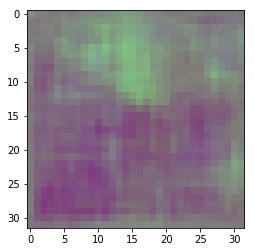

/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[Training Epoch: 0 	n_iter: 50 	Loss: 138660.515625]


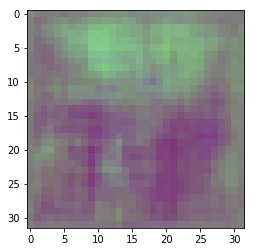

Process Process-7:
Process Process-8:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/anaconda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/anaconda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/anaconda/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlo

KeyboardInterrupt: 

In [28]:
#writer=SummaryWriter()

try:
    model = torch.load('./model/dVAE.pkl')
    print("\n================== Model Restored ==================\n")
except:
    print("\n============== No Model to be Restored ==============\n")
    pass

for i in range(num_epoch):
    for batch_idx,[image,_] in enumerate(train_loader):
        n_iter = (i*len(train_loader))+batch_idx
        
        if use_gpu:
            x=Variable(image).cuda()
        else:
            x=Variable(image)
        # x: batchsize x 3 x 32 x 32
        optimizer.zero_grad()
        
        reconstructed_image=model(x)
        
        loss=loss_func(reconstructed_image,x,model.z_mu,model.z_logvar)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx%50==0:
            print('[Training Epoch: {} \tn_iter: {} \tLoss: {:.6f}]'.format(
                i, n_iter, loss.data[0]))
            plt.imshow(reconstructed_image.cpu().data[0].numpy().transpose(1,2,0), cmap='hsv')
            plt.show(block=True)
            
            
        if batch_idx%200==0:
            torch.save(model,'./model/dVAE_'+str(batch_idx)+'.pkl')
            torch.save(model,'./model/dVAE.pkl')
            
#        writer.add_scalar('loss',loss.data[0] / len(x),n_iter)
  

In [123]:
reconstructed_image.cpu().data[0].numpy().transpose(1,2,0)

array([[[ 0.50167495,  0.51882547,  0.50488049],
        [ 0.50362229,  0.52110022,  0.50821853],
        [ 0.50677085,  0.52629131,  0.5122872 ],
        ..., 
        [ 0.50487953,  0.52528012,  0.51094961],
        [ 0.50053352,  0.51937765,  0.50787246],
        [ 0.49801102,  0.51467299,  0.50054884]],

       [[ 0.50242889,  0.5182777 ,  0.50406826],
        [ 0.50056952,  0.51543373,  0.50166714],
        [ 0.50297159,  0.52127045,  0.50581604],
        ..., 
        [ 0.50049061,  0.51908678,  0.5037871 ],
        [ 0.49627137,  0.51254183,  0.50101703],
        [ 0.49686319,  0.51339757,  0.4998073 ]],

       [[ 0.50129682,  0.51576805,  0.4953188 ],
        [ 0.49827197,  0.51334023,  0.49408391],
        [ 0.50127959,  0.51948518,  0.50065577],
        ..., 
        [ 0.49968538,  0.51727796,  0.49878773],
        [ 0.49528018,  0.51164144,  0.4942739 ],
        [ 0.49547273,  0.51017439,  0.49070603]],

       ..., 
       [[ 0.49100497,  0.49029741,  0.44566473],
        

## Sample results

In [ ]:
example_z = Variable(torch.FloatTensor(8*8*z_dim).normal_(0,1).view(64,-1))

samples = model.decoder(example_z).data.numpy()
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(8, 8)
gs.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(32, 32,3).transpose(1,2,0), cmap='hsv')
fig.savefig("generated_images_by_{}epochs.png".format(num_epoch))